In [1]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Cargar la data
df = pd.read_csv("caso6_prestamos_personales.csv")


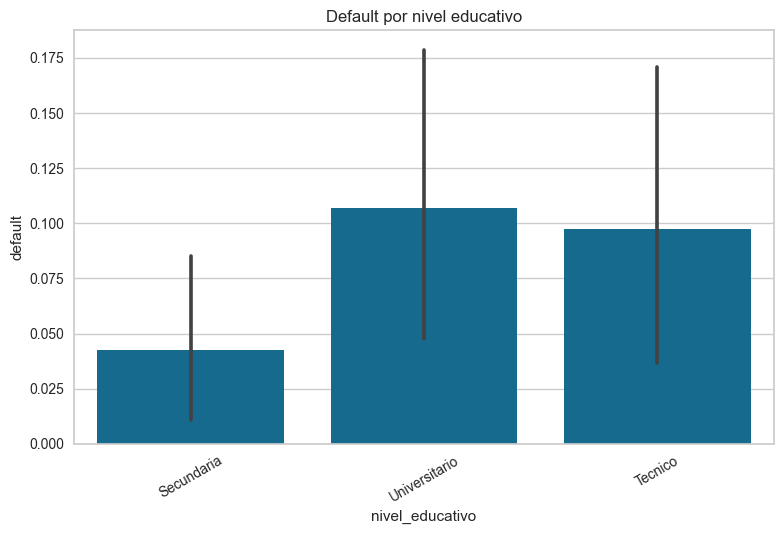

In [2]:

# 2. Análisis exploratorio y posibles sesgos por nivel educativo
sns.barplot(data=df, x='nivel_educativo', y='default')
plt.title("Default por nivel educativo")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [4]:
df.head(3)

,edad,ingreso_mensual,hist_crediticia,nivel_educativo,tiempo_laboral_meses,cuota_vs_ingreso,default,riesgo_cuota,estabilidad_laboral
0,30,3926,Buena,Secundaria,53,0.32,0,23.704151,Estable
1,59,6074,Buena,Secundaria,107,0.13,0,7.379626,Estable
2,62,4739,Buena,Secundaria,22,0.25,0,53.852273,Intermedio


In [3]:

# 3. Feature engineering no trivial
df['riesgo_cuota'] = df['cuota_vs_ingreso'] * df['ingreso_mensual'] / df['tiempo_laboral_meses']
df['estabilidad_laboral'] = pd.cut(df['tiempo_laboral_meses'], bins=[0, 12, 36, 120, 240],
                                   labels=['Nuevo', 'Intermedio', 'Estable', 'Veterano'])


In [9]:

# 4. Configuración PyCaret con enfoque explicativo y ético
clf = setup(data=df,
            target='default',
            session_id=2025,
            categorical_features=['hist_crediticia', 'nivel_educativo', 'estabilidad_laboral'],
            ignore_features=['cuota_vs_ingreso'],  # ya se incluye en otra variable
            transformation=True,
            polynomial_features=True,
            bin_numeric_features=['edad', 'ingreso_mensual'],
            remove_multicollinearity=True,
            multicollinearity_threshold=0.85,
            verbose=False)



In [10]:

# 5. Comparación por Recall (prioriza detectar malos clientes)
best_model = compare_models(sort='Recall')


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6550,0.5811,0.3500,0.0871,0.1368,0.0143,0.0181,0.0650
lda,Linear Discriminant Analysis,0.8906,0.6403,0.3000,0.2700,0.2786,0.2357,0.2381,0.0640
svm,SVM - Linear Kernel,0.7553,0.4219,0.2000,0.0167,0.0305,0.0013,0.0081,0.0690
dt,Decision Tree Classifier,0.8243,0.5149,0.1500,0.0810,0.1022,0.0246,0.0248,0.1040
ada,Ada Boost Classifier,0.8848,0.5881,0.0500,0.0500,0.0500,0.0132,0.0104,0.0940
gbc,Gradient Boosting Classifier,0.8795,0.6224,0.0500,0.0167,0.0250,-0.0131,-0.0122,0.0850
et,Extra Trees Classifier,0.8904,0.6267,0.0500,0.0250,0.0333,0.0024,0.0038,0.1170
lr,Logistic Regression,0.8959,0.6452,0.0000,0.0000,0.0000,-0.0214,-0.0225,1.1760
knn,K Neighbors Classifier,0.9067,0.4646,0.0000,0.0000,0.0000,-0.0139,-0.0145,1.3180
ridge,Ridge Classifier,0.9126,0.5335,0.0000,0.0000,0.0000,-0.0075,-0.0081,0.0540


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8947,0.7941,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8421,0.7941,0.0000,0.0000,0.0000,-0.0755,-0.0808
2,0.9444,0.9412,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9444,0.7059,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9444,0.2059,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9444,0.0882,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9444,0.7353,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8333,0.7031,0.0000,0.0000,0.0000,-0.0800,-0.0857
8,0.8889,0.8594,0.0000,0.0000,0.0000,0.0000,0.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7368,0.5588,0.0000,0.0000,0.0000,-0.1446,-0.1485
1,0.8421,0.7353,0.0000,0.0000,0.0000,-0.0755,-0.0808
2,0.8889,0.9412,0.0000,0.0000,0.0000,-0.0588,-0.0588
3,0.7778,0.8235,0.0000,0.0000,0.0000,-0.0909,-0.1085
4,0.8333,0.0000,0.0000,0.0000,0.0000,-0.0800,-0.0857
5,0.7778,0.1765,0.0000,0.0000,0.0000,-0.0909,-0.1085
6,0.9444,0.9412,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7778,0.8750,0.0000,0.0000,0.0000,-0.1250,-0.1250
8,0.9444,0.9688,0.5000,1.0000,0.6667,0.6400,0.6860


Fitting 10 folds for each of 10 candidates, totalling 100 fits


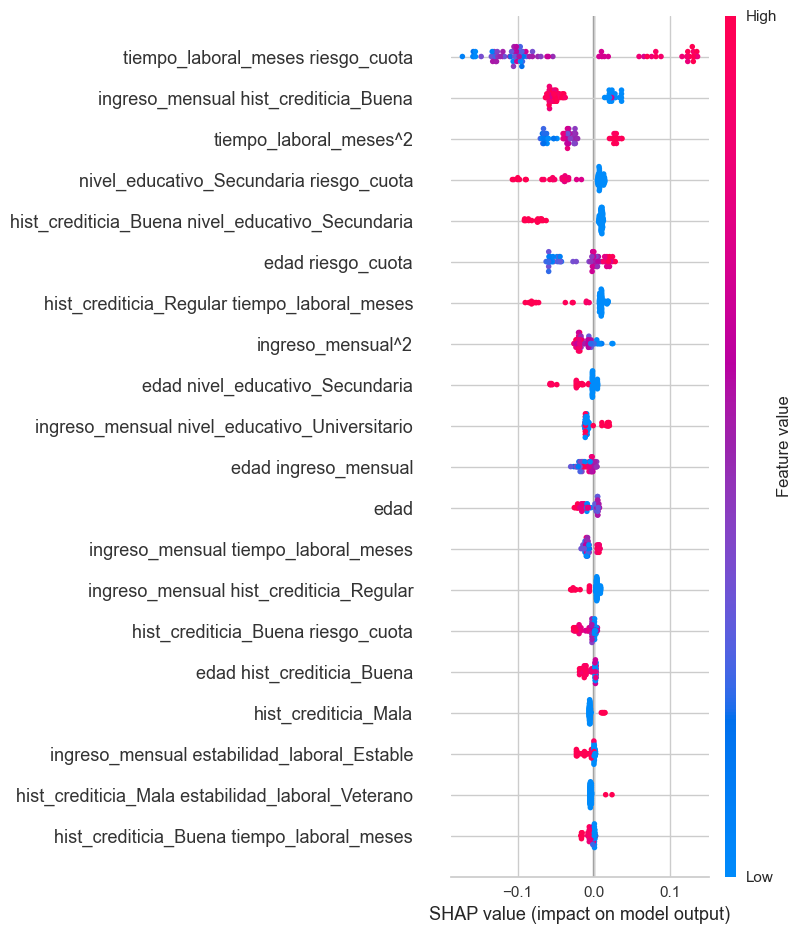

In [12]:

# 6. Ajustar y afinar con F1 score
from pycaret.classification import create_model, tune_model, interpret_model

# Crear y tunear un modelo de árbol
modelo_arbol = create_model('rf')
modelo_tuneado = tune_model(modelo_arbol, optimize='F1')

# Interpretar el modelo
interpret_model(modelo_tuneado)


In [ ]:

# 7. Simular un cliente en riesgo y mejorar su perfil
cliente_riesgoso = pd.DataFrame({
    'edad': [24],
    'ingreso_mensual': [1500],
    'hist_crediticia': ['Regular'],
    'nivel_educativo': ['Tecnico'],
    'tiempo_laboral_meses': [6],
    'riesgo_cuota': [600 * 1500 / 6],  # cuota vs ingreso estimado
    'estabilidad_laboral': ['Nuevo']
})

cliente_mejorado = cliente_riesgoso.copy()
cliente_mejorado['ingreso_mensual'] = 2500
cliente_mejorado['tiempo_laboral_meses'] = 24
cliente_mejorado['riesgo_cuota'] = 600 * 2500 / 24
cliente_mejorado['estabilidad_laboral'] = 'Intermedio'

print("🔍 Riesgo actual:")
print(predict_model(final, data=cliente_riesgoso))

print("Riesgo si mejora estabilidad:")
print(predict_model(final, data=cliente_mejorado))


In [ ]:

# 8. Exportar modelo para conectarlo con API externa
save_model(final, 'modelo_scoring_credito_final')
